# Sentiment Analysis Using Bag-of-Words

:::{contents}

:::

- Sentiment analysis is to analyze the textual documents and extract information that is related to the author's sentiment or opinion. It is sometimes referred to as **opinion mining**.
- It is popular and widely used in industry, e.g., corporate surveys, feedback surveys, social media data, reviews for movies, places, hotels, commodities, etc..
- The sentiment information from texts can be crucial to further **decision making** in the industry.

- Output of Sentiment Analysis
    - Qualitative: overall sentiment scale (positive/negative)
    - Quantitative: sentiment polarity scores

- In this tutorial, we will use movie reviews as an example.
- And the classification task is simple: to classify the document into one of the two classes, i.e., positive or negative.
- Most importantly, we will be using mainly the module `sklearn` for creating and training the classifier.

In [1]:
import nltk, random
from nltk.corpus import movie_reviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

```python
## Colab Only
nltk.download('movie_reviews')
!pip install lime textblob afinn
```

## Data Loading

- We will use the corpus `nlkt.corpus.movie_reviews` as our data.
- Please download the corpus if you haven't.

In [2]:
print(len(movie_reviews.fileids()))
print(movie_reviews.categories())
print(movie_reviews.words()[:100])
print(movie_reviews.fileids()[:10])

2000
['neg', 'pos']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']


- Rearrange the corpus data as a list of tuple, where the first element is the word tokens of the documents, and the second element is the label of the documents (i.e., sentiment labels).

In [3]:
documents = [(' '.join((movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents[:5]


[('plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what \' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn \' t snag this one correctly . they seem to have taken this pretty neat concept , but executed it terribly . so what are the problems with the movie ? well , its main problem is that it \' s simply too jumbled . it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have n

## Corpus Profile

- Important descriptive statistics:
    - Corpus Size (Number of Documents)
    - Corpus Size (Number of Words)
    - Distribution of the Two Classes
- It is important to always report the above necessary descriptive statistics when presenting your classifiers.

In [4]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Corpus Size (words): {}'.format(np.sum([len(d) for (d,l) in documents])))
print('Max Doc Size (words): {}'.format(np.max([len(d) for (d,l) in documents])))
print('Min Doc Size (words): {}'.format(np.min([len(d) for (d,l) in documents])))
print('Average Doc Size (words): {}'.format(np.mean([len(d) for (d,l) in documents])))
print('Sample Text of Doc 1:')
print('-'*30)
print(' '.join(documents[0][:50])) # first 50 words of the first document

Number of Reviews/Documents: 2000
Corpus Size (words): 7808520
Max Doc Size (words): 15097
Min Doc Size (words): 91
Average Doc Size (words): 3904.26
Sample Text of Doc 1:
------------------------------
plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn ' t snag this one correctly . they seem to have taken this pretty neat concept , but executed it terribly . so what are the problem

In [5]:
## Check Sentiment Distribution of the Current Dataset
from collections import Counter
sentiment_distr = Counter([label for (words, label) in documents])
print(sentiment_distr)

Counter({'neg': 1000, 'pos': 1000})


## Random Shuffle

- Shuffling the training data randomizes the order in which samples are presented to the model during training. This prevents the model from learning any patterns or sequences in the data that might not generalize well to unseen data.
- Shuffling helps prevent the model from memorizing the order of samples, ensuring it focuses on learning the underlying patterns in the data.
- It improves the generalizability of the model by reducing the risk of overfitting to specific patterns in the training data.
- Shuffling is particularly important when dealing with imbalanced datasets, as it ensures that each batch or epoch contains a representative sample of the entire dataset [4].

In [6]:
import random

random.seed(123)
random.shuffle(documents)

:::{note}
Specifying a random seed in Python is essential for ensuring reproducibility in random processes. By setting a seed value before generating random numbers, it initializes the pseudo-random number generator to produce the same sequence of random values each time the code is executed with the same seed, thus guaranteeing consistent results across different runs. This is particularly useful in situations where you need deterministic behavior, such as debugging, testing, or ensuring consistent model training outcomes in machine learning
:::

## Data Preprocessing

- Depending on our raw data, we may need data preprocessing before feature engineering so as to remove irrelevant information from our data.
- In this example, bag-of-word methods require very little preprocessing.

## Train-Test Split

- We split the entire dataset into two parts: training set and testing set.
- The proportion of training and testing sets may depend on the corpus size.
- In the train-test split, make sure the the distribution of the classes is proportional.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(documents, test_size = 0.33, random_state=42)

In [8]:
## Sentiment Distrubtion for Train and Test
print(Counter([label for (text, label) in train]))
print(Counter([label for (text, label) in test]))

Counter({'neg': 674, 'pos': 666})
Counter({'pos': 334, 'neg': 326})


- Because in most of the ML steps, the feature sets and the labels are often separated as two units, we split our training data into `X_train` and `y_train` as the **features** (X) and **labels** (y) in training.
- Likewise, we split our testing data into `X_test` and `y_test` as the **features** (X) and **labels** (y) in testing.

In [9]:
X_train = [text for (text, label) in train]
X_test = [text for (text, label) in test]
y_train = [label for (text, label) in train]
y_test = [label for (text, label) in test]

## Text Vectorization

- In feature-based machine learning, we need to vectorize texts into feature sets (i.e., feature engineering on texts).
- We use the naive bag-of-words text vectorization. In particular, we use the weighted version of BOW.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df = 10, token_pattern = r'[a-zA-Z]+')
X_train_bow = tfidf_vec.fit_transform(X_train) # fit train
X_test_bow = tfidf_vec.transform(X_test) # transform test

- Important Notes:
    - Always split the data into train and test first **before** vectorizing the texts
    - Otherwise, you would leak information to the training process, which may lead to over-fitting
    - When vectorizing the texts, `fit_transform()` on the **training** set and `transform()` on the **testing** set.
    - Always report the number of features used in the model.

In [11]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1340, 6138)
(660, 6138)


## Model Selection and Cross Validation

- For our current binary sentiment classifier, we will try a few common classification algorithms:
    - Support Vector Machine
    - Decision Tree
    - Naive Bayes
    - Logistic Regression
    

- The common steps include:
    - We fit the model with our training data.
    - We check the model stability, using **k-fold cross validation** on the training data.
    - We use the fitted model to make prediction.
    - We evaluate the model prediction by comparing the predicted classes and the true labels.

### SVM

In [12]:
from sklearn import svm

model_svm = svm.SVC(C=8.0, kernel='linear')
model_svm.fit(X_train_bow, y_train)

SVC(C=8.0, kernel='linear')

In [13]:
from sklearn.model_selection import cross_val_score
model_svm_acc = cross_val_score(estimator=model_svm, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_svm_acc

array([0.84328358, 0.82089552, 0.85447761, 0.82462687, 0.84701493])

In [14]:
model_svm.predict(X_test_bow[:10])
#print(model_svm.score(test_text_bow, test_label))

array(['pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=10, random_state=0)
model_dec.fit(X_train_bow, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [16]:
model_dec_acc = cross_val_score(estimator=model_dec, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_dec_acc

array([0.6641791 , 0.64179104, 0.66791045, 0.64179104, 0.6380597 ])

In [17]:
model_dec.predict(X_test_bow[:10])

array(['pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg',
       'neg'], dtype='<U3')

### Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train_bow.toarray(), y_train)

GaussianNB()

In [19]:
model_gnb_acc = cross_val_score(estimator=model_gnb, X=X_train_bow.toarray(), y=y_train, cv=5, n_jobs=-1)
model_gnb_acc

array([0.7238806 , 0.67164179, 0.7238806 , 0.68656716, 0.68283582])

In [20]:
model_gnb.predict(X_test_bow[:10].toarray())

array(['pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg'], dtype='<U3')

### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

model_lg = LogisticRegression()
model_lg.fit(X_train_bow, y_train)

LogisticRegression()

In [22]:
model_lg_acc = cross_val_score(estimator=model_lg, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_lg_acc

array([0.83208955, 0.79477612, 0.82462687, 0.78731343, 0.82835821])

In [23]:
model_lg.predict(X_test_bow[:10].toarray())

array(['pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

### Cross Validation (LR as an example)

- Cross-validation is a technique used in machine learning to assess how well a predictive model will perform on unseen data. 
- By dividing the dataset into multiple subsets, it trains the model on a portion of the data and evaluates it on the remaining data. 
- This process is repeated several times, with each subset serving as both training and validation data. 
- Benefits of Cross-validation: 
    - provides more reliable estimates of model performanc
    - reduces overfitting by testing the model on different data subsets
    - maximizes data utilization
    - facilitates hyperparameter tuning
    - assesses the model's generalization ability (biases vs. variation)

In [67]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(model_lg,          ## base model
                         X_train_bow,       ## X
                         y_train,           ## y
                         cv=10)             ## 10-fold cross-validation

# Print scores
print(scores)
print("Average Score:", scores.mean())

[0.82089552 0.82089552 0.79104478 0.80597015 0.85074627 0.82835821
 0.80597015 0.79850746 0.82835821 0.8358209 ]
Average Score: 0.8186567164179104


You can perform cross-validation using the other classifiers to see which machine learning algorithm gives you the more stable predictions on the training set.

## Evaluation

- To evaluate each model's performance, there are several common metrics in use:
    - Precision
    - Recall
    - F-score
    - Accuracy
    - Confusion Matrix

In [24]:
#Mean Accuracy
print(model_svm.score(X_test_bow, y_test))
print(model_dec.score(X_test_bow, y_test))
print(model_gnb.score(X_test_bow.toarray(), y_test))
print(model_lg.score(X_test_bow, y_test))

0.8075757575757576
0.65
0.7015151515151515
0.7954545454545454


In [25]:
# F1
from sklearn.metrics import f1_score

y_pred = model_svm.predict(X_test_bow)

f1_score(y_test, y_pred,
         average=None,
         labels = movie_reviews.categories())

array([0.80248834, 0.81240768])

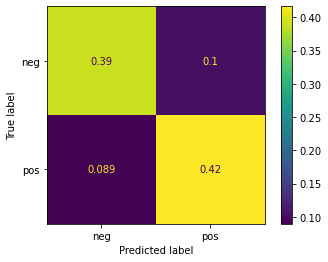

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_svm, X_test_bow, y_test, normalize='all')

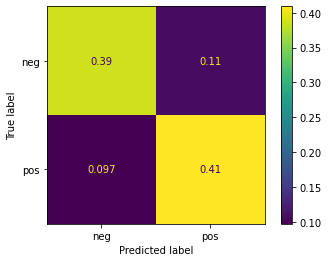

In [27]:
ConfusionMatrixDisplay.from_estimator(model_lg, X_test_bow.toarray(), y_test, normalize='all')

In [28]:
## try a whole new self-created review:)
new_review =['This book looks soso like the content but the cover is weird',
             'This book looks soso like the content and the cover is weird'
            ]
new_review_bow = tfidf_vec.transform(new_review)
model_svm.predict(new_review_bow)

array(['neg', 'neg'], dtype='<U3')

## Tuning Model Hyperparameters - Grid Search

- For each model, we have not optimized it in terms of its hyperparameter setting.
- Now that SVM seems to perform the best among all, we take this as our base model and further fine-tune its hyperparameter using **cross-validation** and **Grid Search**.

In [29]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=10, n_jobs=-1) ## `-1` run in parallel
clf.fit(X_train_bow, y_train)

/Users/alvinchen/anaconda3/envs/python-notes/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 2.14 s, sys: 71.8 ms, total: 2.21 s
Wall time: 26.3 s


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

- We can check the parameters that yield the most optimal results in the Grid Search:

In [30]:
#print(sorted(clf.cv_results_.keys()))
print(clf.best_params_)

{'C': 1, 'kernel': 'linear'}


In [31]:
print(clf.score(X_test_bow, y_test))

0.8106060606060606


## Post-hoc Analysis

- After we find the optimal classifier, next comes the most important step: interpret the classifier.
- A good classifier may not always perform as we have expected. Chances are that the classifier may have used cues that are unexpected for decision making.
- In the post-hoc analysis, we are interested in:
    - Which features contribute to the classifier's prediction the most?
    - Which features are more relevant to each class prediction?

- We will introduce three methods for post-hoc analysis:
    - LIME
    - Model coefficients and feature importance
    - Permutation importances

### LIME

- Using LIME (Local Interpretable Model-agnostic Explanations) to interpret the **importance of the features** in relation to the model prediction.
- LIME was introduced in 2016 by Marco Ribeiro and his collaborators in a paper called [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938)
- Its objective is to explain a model prediction for a specific text sample in a human-interpretable way.

- What we have done so far tells us that the model accuracy is good, but **we have no idea whether the classifier has learned features that are useful and meaningful**.
- How can we identify important words that may have great contribution to the model prediction?

In [32]:
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline

In [33]:
## define the pipeline
pipeline = Pipeline([
  ('vectorizer',tfidf_vec),
  ('clf', svm.SVC(C=1, kernel='linear', probability=True))])

## Refit model based on optimal parameter settings
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, token_pattern='[a-zA-Z]+')),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

In [34]:
import textwrap
reviews_test = X_test
sentiments_test = y_test



# We choose a sample from test set
idx = 210
text_sample = reviews_test[idx]
class_names = ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample,400))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative) =', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-210:
--------------------------------------------------
Review Text:
 in ` enemy at the gates ' , jude law is a gifted russian sniper made hero by a political officer named danilov ( joseph fiennes ) who uses him in a propaganda newspaper to raise the hopes of the soldiers and people of stalingrad . it ' s world war ii , and the russian - german standoff in town could determine the outcome of things for the motherland . law ' s vassili is the russian ' s top pawn to
victory . lots of war stuff happens . an older , german version of jude ' s character played by ed harris shows up halfway into the proceedings . he ' s equally talented , and the two men play a cat and mouse game trying to kill each other . they constantly switch roles , as the war fades far into the background . the cast also includes the terrific rachel weisz as a love interest for both vassili
and danilov the set - up is decent , and so are the production values . boasting a wide range of grimy locales , greas

In [35]:
import matplotlib
matplotlib.rcParams['figure.dpi']=300
%matplotlib inline


explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample,
                                         pipeline.predict_proba,
                                         num_features=20)
explanation.show_in_notebook(text=True)

### Model Coefficients and Feature Importance

- Another way to evaluate the importance of the features is to look at their corresponding coefficients.
    - Positive weights imply positive contribution of the feature to the prediction; negative weights imply negative contribution of the feature to the prediction.
    - The absolute values of the weights indicate the effect sizes of the features.
- Not all ML models provide "coefficients".

In [36]:
## Extract the coefficients of the model from the pipeline
importances = pipeline.named_steps['clf'].coef_.toarray().flatten()
## Select top 10 positive/negative weights
top_indices_pos = np.argsort(importances)[::-1][:10]
top_indices_neg = np.argsort(importances)[:10]
## Get featnames from tfidfvectorizer
feature_names = np.array(tfidf_vec.get_feature_names_out()) # List indexing is different from array

In [37]:
feature_importance_df = pd.DataFrame({'FEATURE': feature_names[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'IMPORTANCE': importances[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'SENTIMENT': ['pos' for _ in range(len(top_indices_pos))]+['neg' for _ in range(len(top_indices_neg))]})
feature_importance_df

FEATURE  IMPORTANCE SENTIMENT
0         and    2.718226       pos
1         fun    1.582112       pos
2       rocky    1.577557       pos
3        well    1.555922       pos
4       great    1.486346       pos
5        also    1.441834       pos
6         you    1.385660       pos
7   hilarious    1.382671       pos
8       mulan    1.361607       pos
9        life    1.343015       pos
10        bad   -2.942730       neg
11       plot   -1.982912       neg
12       have   -1.949701       neg
13       even   -1.793556       neg
14     boring   -1.721138       neg
15      worst   -1.675429       neg
16      there   -1.589407       neg
17    nothing   -1.543166       neg
18       only   -1.514030       neg
19        why   -1.442169       neg

Text(0.5, 1.0, 'Feature Importance: Top Words')

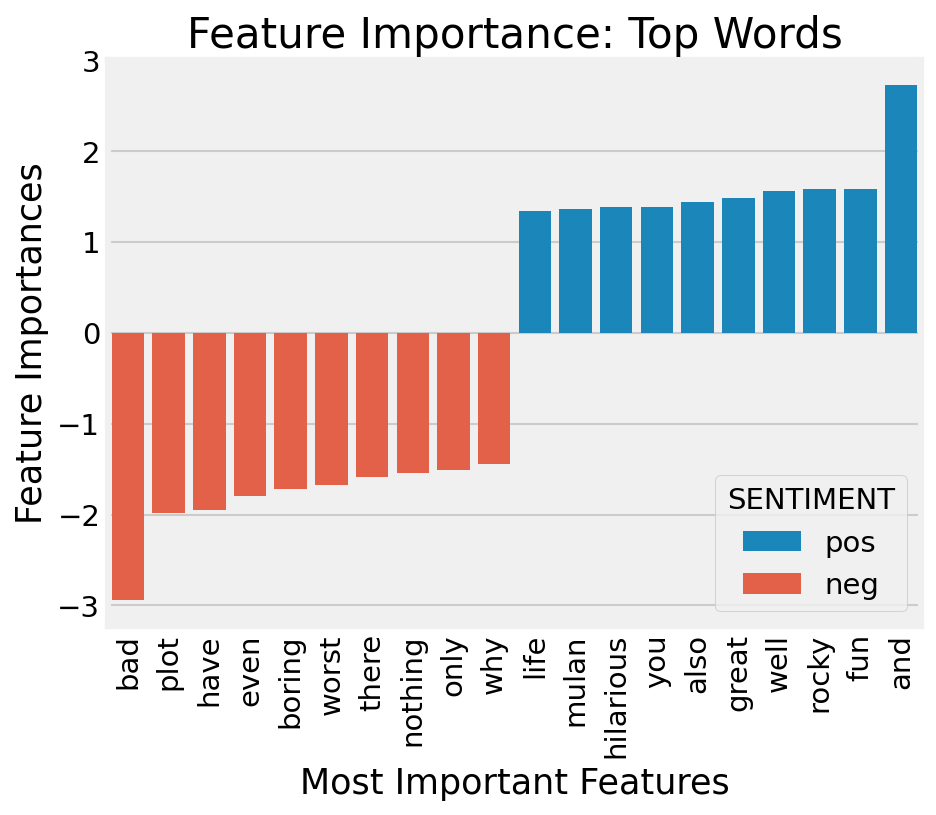

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Barplot (sorted by importance values)
plt.figure(figsize=(7,5), dpi=150)
plt.style.use('fivethirtyeight')
# print(plt.style.available)
# plt.bar(x = feature_importance_df['FEATURE'], height=feature_importance_df['IMPORTANCE'])
sns.barplot(x = 'FEATURE', y = 'IMPORTANCE', data = feature_importance_df,
            hue = 'SENTIMENT', dodge = False,
            order =  feature_importance_df.sort_values('IMPORTANCE').FEATURE)
plt.xlabel("Most Important Features")
plt.ylabel("Feature Importances")
plt.xticks(rotation=90)
plt.title("Feature Importance: Top Words", color="black")

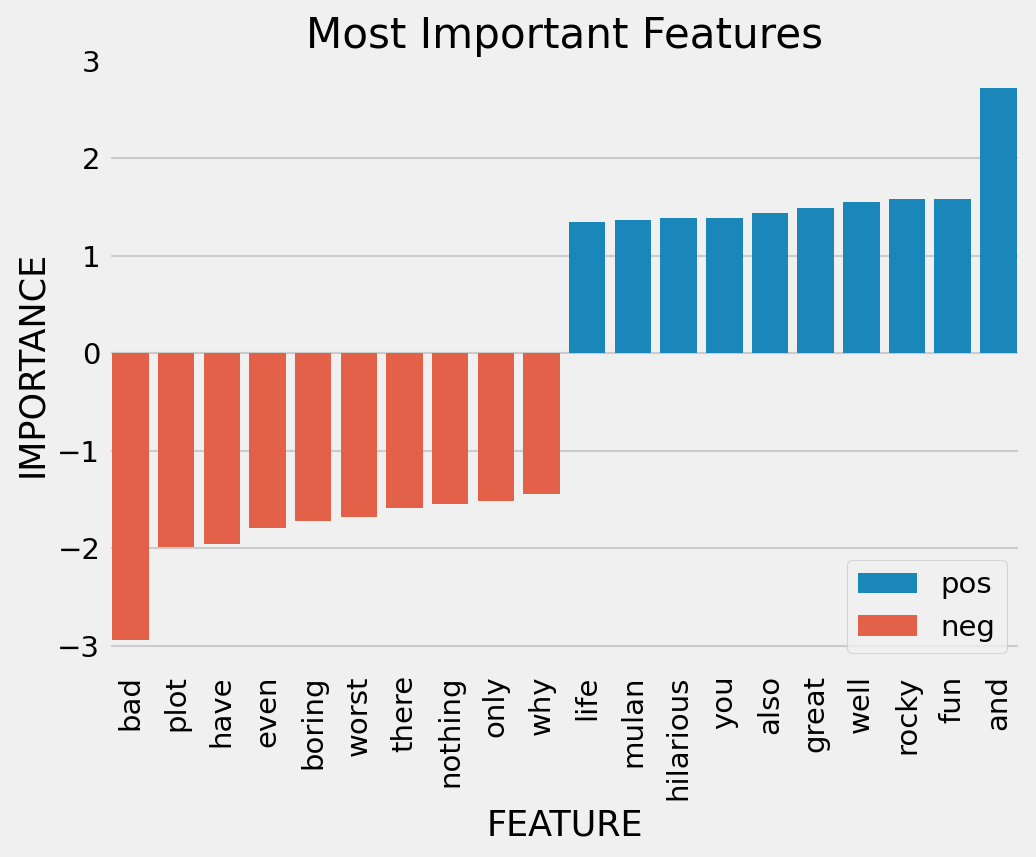

In [39]:
## Barplot sorted by importance values (II)

# Reorder the features based on their importance
feature_importance_df['FEATURE'] = pd.Categorical(feature_importance_df['FEATURE'], ordered=True, categories=feature_importance_df.sort_values('IMPORTANCE')['FEATURE'])

# Create the bar plot
plt.figure(figsize= (7, 5),dpi=150)
sns.barplot(x='FEATURE', y='IMPORTANCE', hue='SENTIMENT', data=feature_importance_df, dodge=False)
plt.title('Most Important Features')
plt.xlabel('FEATURE')
plt.ylabel('IMPORTANCE')
plt.legend(title=None)
plt.xticks(rotation=90)
plt.show()


### Permutation Importances

- Permutation importances measure the impact of shuffling a single feature's values on the model's performance. It quantifies how much the model relies on each feature for making predictions.
- The permutation importance is computed as the decrease in the model's performance (e.g., accuracy) when the values of a particular feature are randomly shuffled. The larger the decrease in performance, the more important the feature is considered to be.
    - Positive permutation importance indicates that shuffling the feature leads to a significant drop in model performance, suggesting higher importance of that feature.
    - Negative permutation importance suggests that shuffling the feature has little impact on model performance, indicating lower importance or redundancy of that feature.

- See `sklearn` documentation: [4.2 Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

:::{tip}

On which dataset (training, held-out, or testing sets) should be performed the permutation importance computation?

It is suggested to use a held-out set, which makes it possible to highlight which features contribute the most to the generalization power of the classifier (i.e., to avoid overfitting problems).

:::

In [40]:
%%time
from sklearn.inspection import permutation_importance

## permutation importance
r = permutation_importance(model_lg,                ## classifier
                           X_test_bow.toarray(),    ## featuresets
                           y_test,                  ## target labels
                           n_repeats=5,             ## times of permutation
                           random_state=0,          ## random seed
                           n_jobs=-1                ## `-1` parallel processing
                           )

CPU times: user 3.19 s, sys: 985 ms, total: 4.18 s
Wall time: 18.6 s


In [41]:
## checking
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

and     0.023 +/- 0.005
bad     0.012 +/- 0.004
is      0.008 +/- 0.004
worst   0.007 +/- 0.002
he      0.005 +/- 0.001
harry   0.005 +/- 0.001
well    0.005 +/- 0.002
will    0.004 +/- 0.001
october 0.004 +/- 0.001
things  0.003 +/- 0.001
unfortunately0.003 +/- 0.001
lame    0.003 +/- 0.001
which   0.003 +/- 0.001
ending  0.003 +/- 0.001
zeta    0.003 +/- 0.000
finds   0.003 +/- 0.000
jackie  0.003 +/- 0.001
violence0.003 +/- 0.001
others  0.003 +/- 0.001
characters0.002 +/- 0.001
problem 0.002 +/- 0.001
death   0.002 +/- 0.001
while   0.002 +/- 0.001
perfect 0.002 +/- 0.001
charlie 0.002 +/- 0.001
hanks   0.002 +/- 0.001
bright  0.002 +/- 0.001
henry   0.002 +/- 0.001
in      0.002 +/- 0.001
contain 0.002 +/- 0.001
everything0.002 +/- 0.001
first   0.002 +/- 0.001
slightly0.002 +/- 0.001
suffers 0.002 +/- 0.001
terribly0.002 +/- 0.001
won     0.002 +/- 0.001
story   0.002 +/- 0.001
except  0.002 +/- 0.001
science 0.002 +/- 0.001
edition 0.002 +/- 0.001
bond    0.002 +/- 0.001
allows 

### Other Variants

- Some of the online code snippets try to implement the `show_most_informative_features()` in `nltk` classifier.
- Here the codes only work with linear classifiers (e.g., Logistic models) in sklearn.
- Need more updates. See this [SO post](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers)

In [42]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [43]:
show_most_informative_features(tfidf_vec, model_lg, n=20)


	-2.1822	bad            		2.9418	and            
	-1.4587	to             		1.6021	is             
	-1.3789	t              		1.4664	the            
	-1.3346	have           		1.3255	life           
	-1.3056	plot           		1.2625	as             
	-1.2879	boring         		1.2254	his            
	-1.2856	worst          		1.0816	well           
	-1.2116	there          		1.0761	jackie         
	-1.0930	no             		1.0679	also           
	-1.0751	nothing        		1.0662	of             
	-1.0332	even           		1.0106	will           
	-0.9972	movie          		1.0012	great          
	-0.9849	only           		0.9841	mulan          
	-0.9737	why            		0.9832	very           
	-0.9721	supposed       		0.9085	family         
	-0.9452	stupid         		0.8980	war            
	-0.9299	script         		0.8890	perfect        
	-0.9294	harry          		0.8292	rocky          
	-0.9228	be             		0.8281	world          
	-0.9169	waste          		0.8067	many           


- For tree-based classifiers, visualization is better.

In [44]:
import sklearn
from sklearn.tree import plot_tree
text_representation = sklearn.tree.export_text(model_dec, feature_names = tfidf_vec.get_feature_names_out().tolist())
print(text_representation)




|--- bad <= 0.02
|   |--- boring <= 0.02
|   |   |--- and <= 0.16
|   |   |   |--- script <= 0.02
|   |   |   |   |--- hilarious <= 0.01
|   |   |   |   |   |--- any <= 0.02
|   |   |   |   |   |   |--- if <= 0.02
|   |   |   |   |   |   |   |--- awful <= 0.02
|   |   |   |   |   |   |   |   |--- capsule <= 0.02
|   |   |   |   |   |   |   |   |   |--- reason <= 0.05
|   |   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |   |--- reason >  0.05
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |   |--- capsule >  0.02
|   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |--- awful >  0.02
|   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |--- if >  0.02
|   |   |   |   |   |   |   |--- into <= 0.02
|   |   |   |   |   |   |   |   |--- so <= 0.02
|   |   |   |   |   |   |   |   |   |--- becomes <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |  

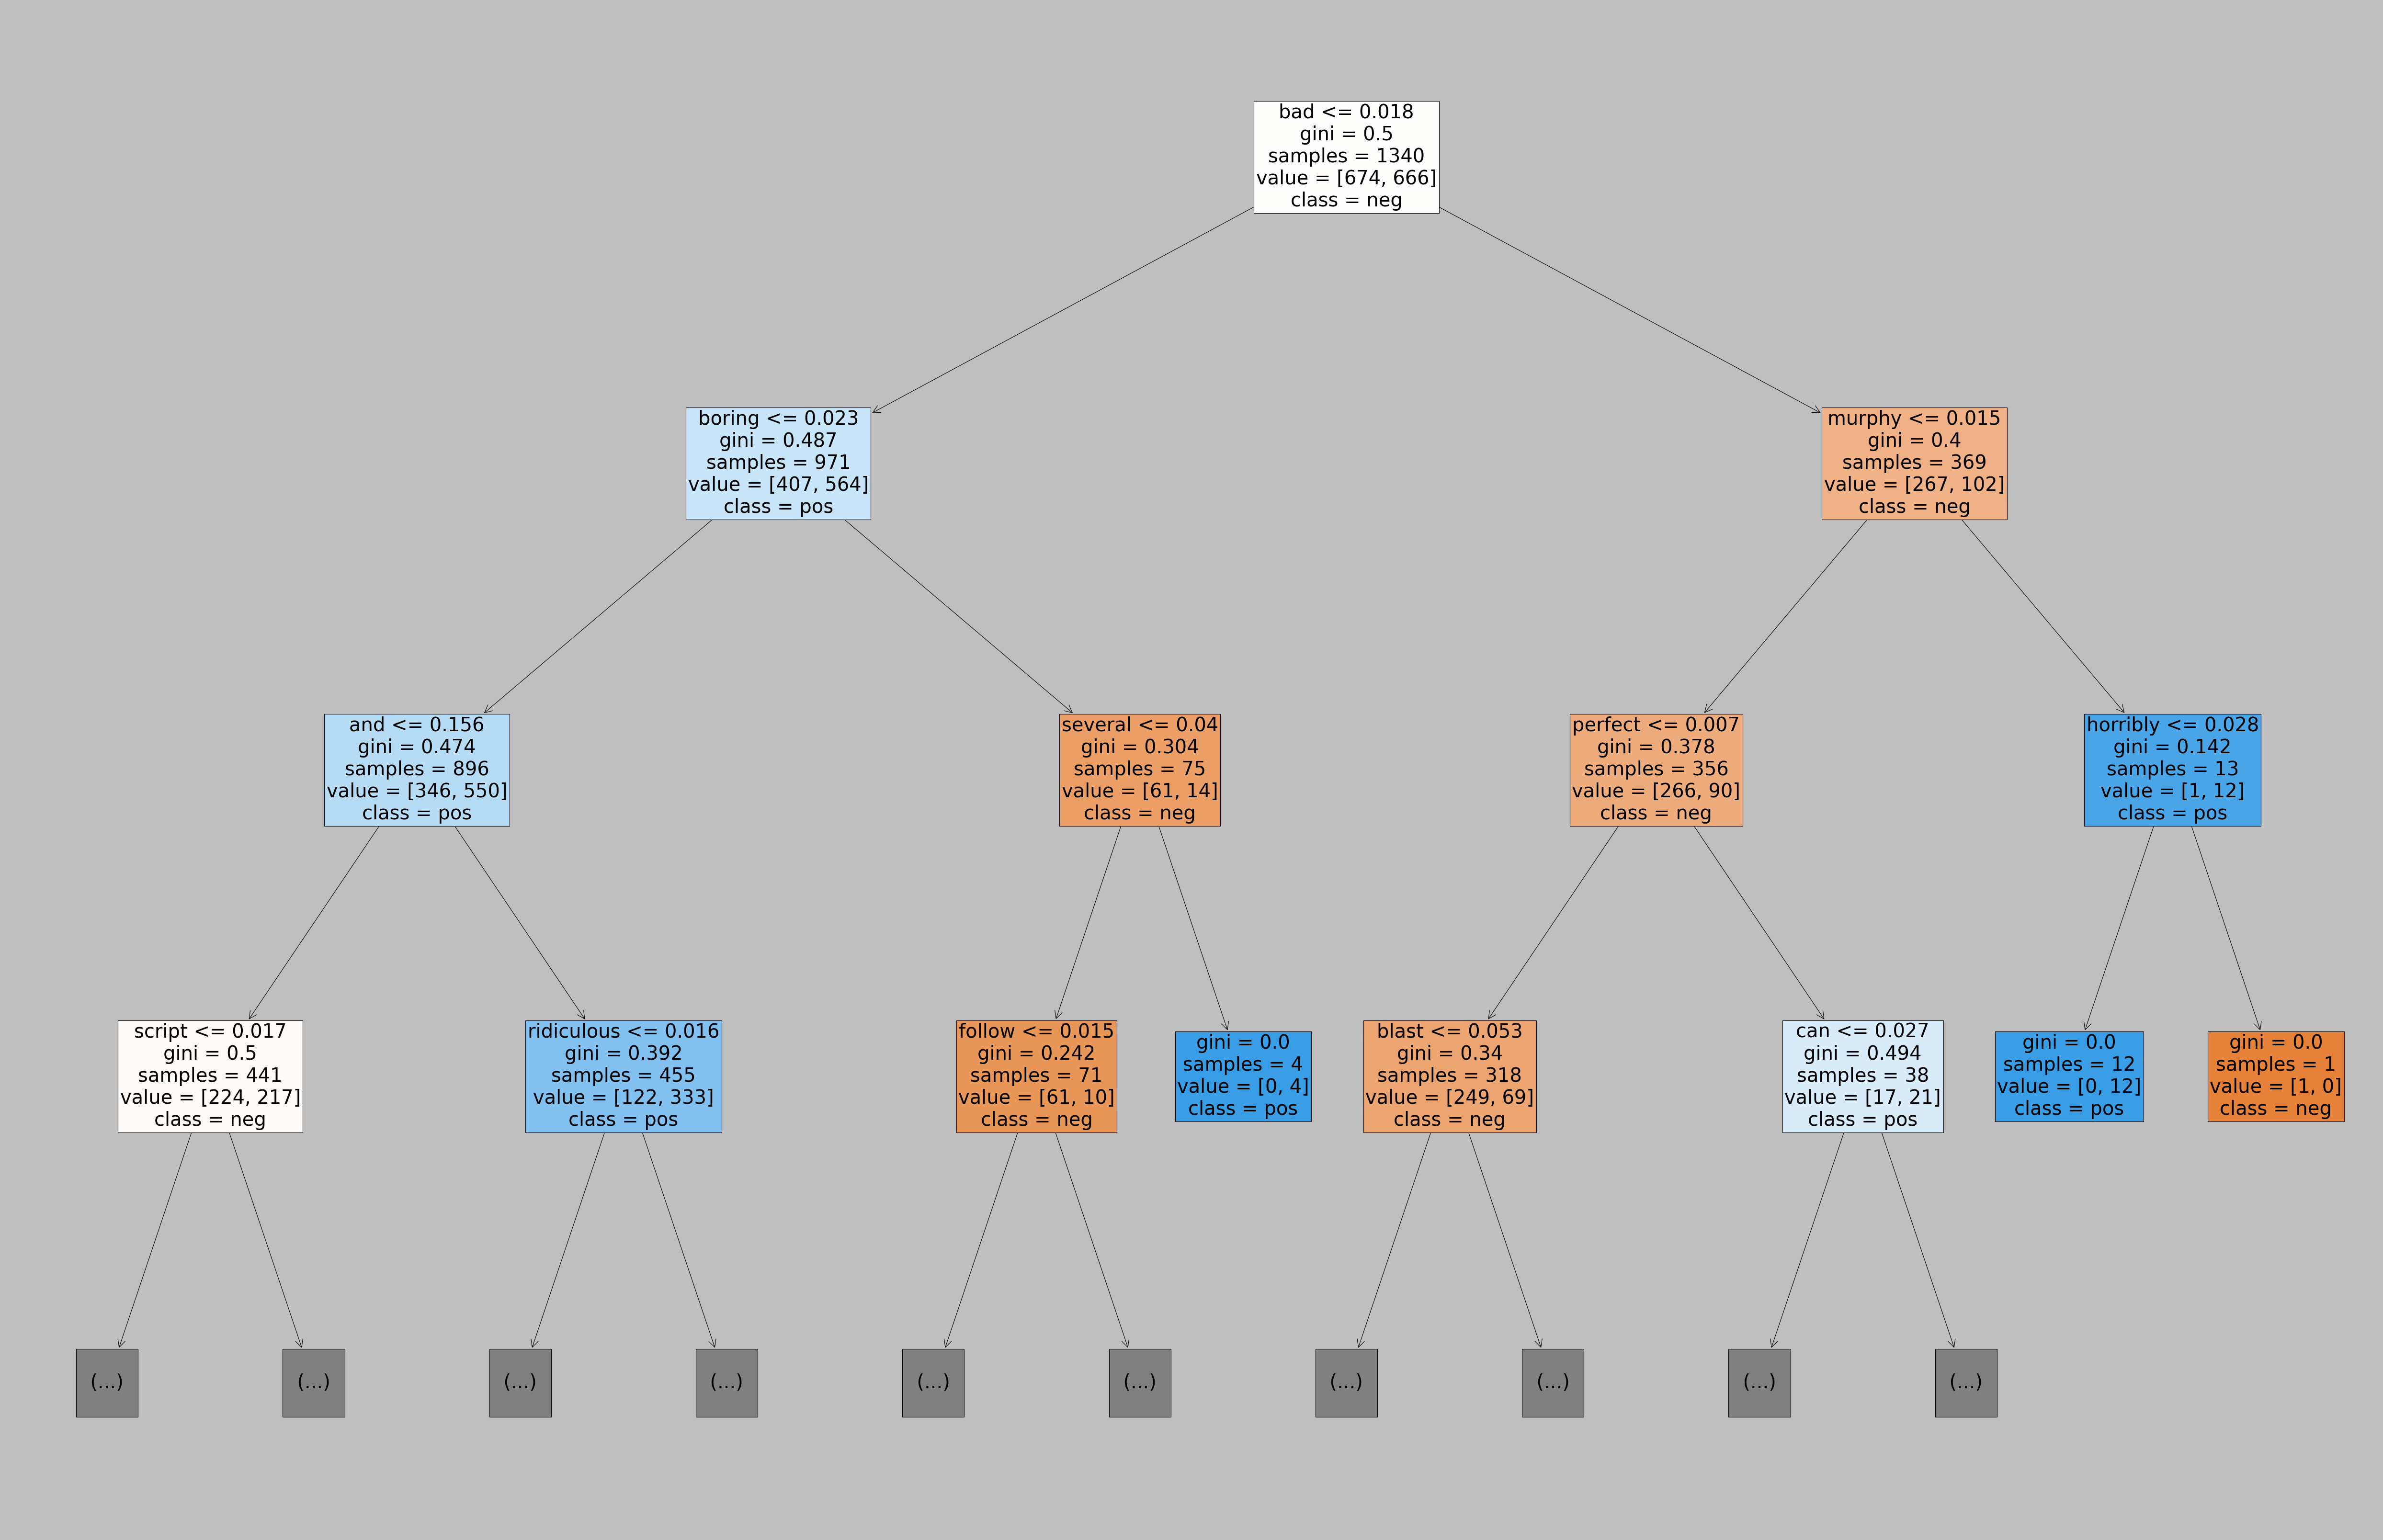

In [45]:
plt.style.use('classic')
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(80,50))
_ = sklearn.tree.plot_tree(model_dec, max_depth=3,
                   feature_names=tfidf_vec.get_feature_names_out().tolist(),  ## parameter requires list
                   class_names=model_dec.classes_.tolist(), ## parameter requires list
                   filled=True, fontsize=36)

#fig.savefig("decistion_tree.png")

## Saving Model


In [46]:
#  import pickle

# with open('../ml-sent-svm.pkl', 'wb') as f:
#     pickle.dump(clf, f)
# with open('../ml-sent-svm.pkl' 'rb') as f:
#     loaded_svm = pickle.load(f)

## Dictionary-based Sentiment Classifier (Self-Study)

- Without machine learning, we can still build a sentiment classifier using a dictionary-based approach.
- Words can be manually annotated with sentiment polarity scores.
- Based on the sentiment dictionary, we can then compute the sentiment scores for a text.

### TextBlob Lexicon

In [47]:
from textblob import TextBlob

In [48]:
doc_sent = TextBlob(X_train[0])
print(doc_sent.sentiment)
print(doc_sent.sentiment.polarity)

Sentiment(polarity=0.15877050157184083, subjectivity=0.5661635487528345)
0.15877050157184083


In [49]:
doc_sents = [TextBlob(doc).sentiment.polarity for doc in X_train]

In [50]:
y_train[:10]

['neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos', 'neg', 'pos']

In [51]:
doc_sents_prediction = ['pos' if score >= 0.1 else 'neg' for score in doc_sents]
doc_sents_prediction[:10]

['pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg']

In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
print(accuracy_score(y_train, doc_sents_prediction))
print(f1_score(y_train, doc_sents_prediction, average=None, labels=['neg','pos']))

0.7425373134328358
[0.74872542 0.73603673]


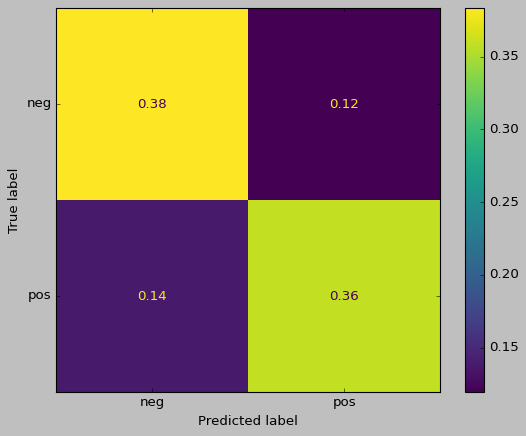

In [53]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_prediction, normalize="all"), display_labels=['neg','pos']).plot()

### AFINN Lexicon

In [54]:
from afinn import Afinn

In [55]:
afn = Afinn(emoticons=True)

afn.score("This movie, not good. worth it :( But can give it a try!! worth it")

0.0

In [56]:
doc_sents_afn = [afn.score(d) for d in X_train]

In [57]:
doc_sents_afn_prediction = ['pos' if score >= 1.0 else 'neg' for score in doc_sents_afn]

In [58]:
print(accuracy_score(y_train, doc_sents_afn_prediction))
print(f1_score(y_train, doc_sents_afn_prediction, average=None, labels=['neg','pos']))

0.6686567164179105
[0.61458333 0.70942408]


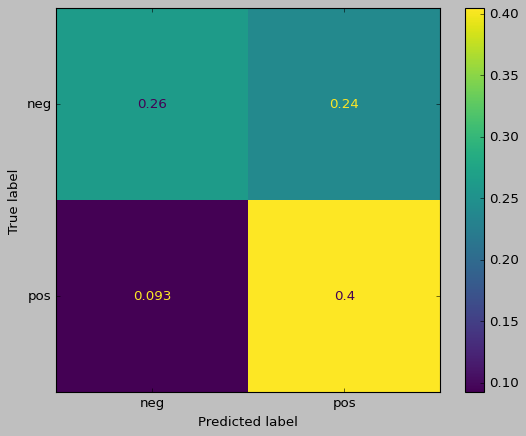

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_afn_prediction, normalize="all"),display_labels=['neg','pos']).plot()

- Disadvantage of Dictionary-based Approach
    - Constructing the sentiment dictionary is time-consuming.
    - The sentiment dictionary can be topic-dependent.


- English Resources for Sentiment Analysis
    - See Sarkar (2019) Chapter 9 Senitment Analysis (on Unsupervised Lexicon-based Models)
    - [`pattern`](https://github.com/clips/pattern)
    - [`textblob`](https://github.com/sloria/TextBlob)
    - [`affin`](https://github.com/fnielsen/afinn)
- Chinese Resources for Sentiment Analysis
    - [`polyglot`](https://polyglot.readthedocs.io/en/latest/Sentiment.html)
    - [`snownlp`](https://github.com/isnowfy/snownlp) (for simplified Chinese)
    - [ANTUSD (The Augmented NTU Sentiment Dictionary)](http://academiasinicanlplab.github.io/#resources)

## Package Requirement

In [60]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

In [61]:
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

afinn==0.1
lime==0.2.0.1
matplotlib==3.7.2
nltk==3.8.1
numpy==1.24.3
pandas==2.0.3
scikit-learn==1.3.0
seaborn==0.12.2
textblob==0.17.1


## References

- Geron (2019), Ch 2 and 3
- Sarkar (2019), Ch 9
- See [Keith Galli's sklearn tutorial](https://github.com/KeithGalli/sklearn)
- See a blog post, [LIME of words: Interpreting RNN Predictions](https://data4thought.com/deep-lime.html).
- See a blog post, [LIME of words: how to interpret your machine learning model predictions](https://data4thought.com/lime-of-words.html)